In [19]:
%matplotlib inline

In [20]:
import torch
from torch import nn, optim
from torchsummary import summary
import torchvision
import numpy as np
import torchvision.transforms as T
import matplotlib.pyplot as plt
import os

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

Device: cuda:0


In [22]:
augs = torchvision.transforms.Compose([
    T.RandomRotation(degrees = (0,30)),
    T.Resize((40,40)),
    T.RandomResizedCrop((32,32), scale = (0.6,1), ratio=(1,1)),
    T.ColorJitter(brightness=0.5, contrast = 0.5, hue = 0.5, saturation=0.5),
    T.RandomHorizontalFlip(),
    T.ToTensor()
])

Load the Cifar10 dataset

In [23]:
batch_size_train = 64
batch_size_test = 64

train_data = torchvision.datasets.CIFAR10(root = './data',
                                          train = True,
                                          download=True,
                                          transform=augs)
test_data = torchvision.datasets.CIFAR10(root = './data',
                                          train = False,
                                          download=True,
                                          transform=T.ToTensor())

train_loader = torch.utils.data.DataLoader(train_data,batch_size = batch_size_train, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size_test, shuffle = True)
print(train_loader)

Files already downloaded and verified
Files already downloaded and verified


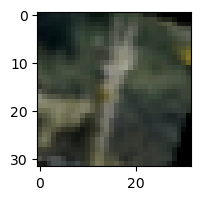

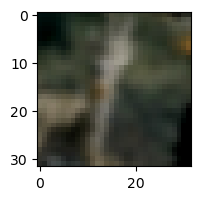

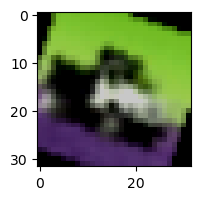

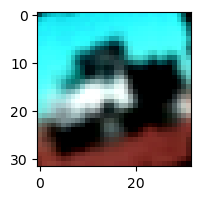

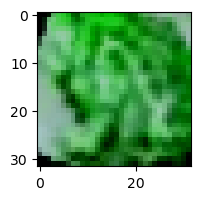

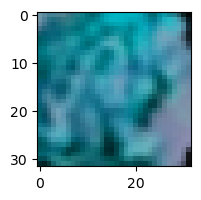

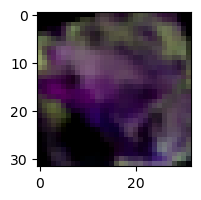

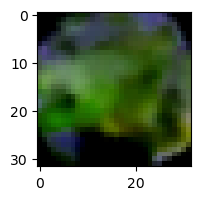

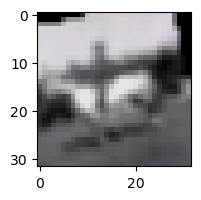

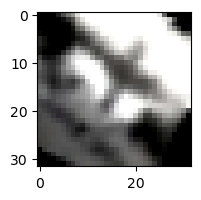

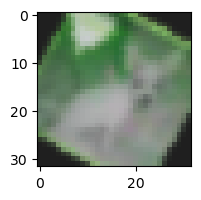

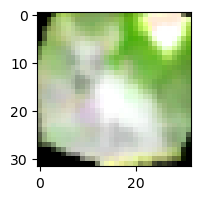

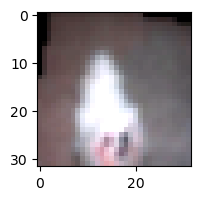

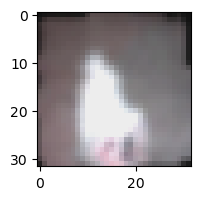

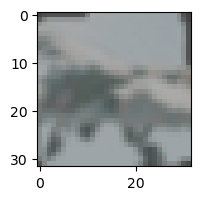

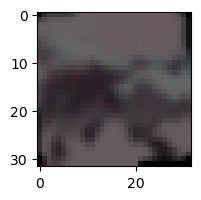

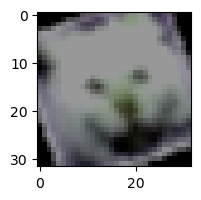

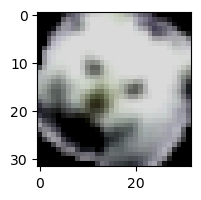

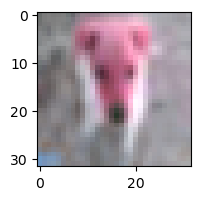

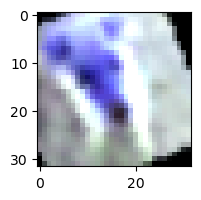

In [24]:
def imshow(img):
    plt.figure(figsize=(2,2))
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))

dataiter = iter(train_loader)
images, labels = next(dataiter)

for i in range(10):
    imshow(torchvision.utils.make_grid(images[i]))
    temp = augs(T.functional.to_pil_image(images[i]))
    imshow(torchvision.utils.make_grid(temp))

Create the model

In [25]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.aug = augs
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size=(3,3), padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=(3,3), padding = 1)
        self.batchnorm1 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=(3,3), padding = 1)
        self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size=(3,3), padding = 1)
        self.batchnorm2 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size=(3,3), padding = 1)
        self.conv6 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size=(3,3), padding = 1)
        self.conv7 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size=(3,3), padding = 1)
        self.batchnorm3 = nn.BatchNorm2d(256)

        self.conv8 = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size=(3,3), padding = 1)
        self.conv9 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size=(3,3), padding = 1)
        self.conv10 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = (3,3), padding = 1)
        self.batchnorm4 = nn.BatchNorm2d(512)

        # self.conv9 = nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size=(3,3), padding = 1)
        # self.conv10 = nn.Conv2d(in_channels = 1024, out_channels = 1024, kernel_size=(3,3), padding = 1)
        # self.batchnorm5 = nn.BatchNorm2d(1024)

        self.avgpool = nn.AvgPool2d(kernel_size=(2,2), stride=2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

        self.linear1 = nn.LazyLinear(64, bias = True)
        self.dropout = nn.Dropout(p = 0.5)
        self.linear2 = nn.Linear(64, 10, bias = True)
        self.softmax = nn.Softmax(-1)

    def forward(self,x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.avgpool(x)
        x = self.batchnorm1(x)

        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.avgpool(x)
        x = self.batchnorm2(x)

        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.relu(self.conv7(x))
        x = self.avgpool(x)
        x = self.batchnorm3(x)

        x = self.relu(self.conv8(x))
        x = self.relu(self.conv9(x))
        x = self.relu(self.conv10(x))
        x = self.avgpool(x)
        x = self.batchnorm4(x)

        # x = self.relu(self.conv9(x))
        # x = self.relu(self.conv10(x))
        # x = self.maxpool(x)
        # x = self.batchnorm5(x)

        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return self.softmax(x)

model = CNN()
model.to(device)
summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         AvgPool2d-5           [-1, 64, 16, 16]               0
       BatchNorm2d-6           [-1, 64, 16, 16]             128
            Conv2d-7          [-1, 128, 16, 16]          73,856
              ReLU-8          [-1, 128, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]         147,584
             ReLU-10          [-1, 128, 16, 16]               0
        AvgPool2d-11            [-1, 128, 8, 8]               0
      BatchNorm2d-12            [-1, 128, 8, 8]             256
           Conv2d-13            [-1, 256, 8, 8]         295,168
             ReLU-14            [-1, 25

Initialize hyperparamters

In [26]:
optimizer = optim.SGD(model.parameters(), momentum = 0.9, lr = 0.001, weight_decay=1e-5)
loss_func = nn.CrossEntropyLoss(reduction = 'mean')
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 4)
num_epochs = 200

Train the model

In [27]:
train_acc_list = []
val_acc_list = []

train_loss_list = []
val_loss_list = []

es_count = 0
curr_epoch = 0
curr_loss = 0

for epoch in range(num_epochs):

    if es_count == 7:
        print("Stop training")
        curr_epoch = epoch
        break
    model.train()
    train_loss = 0
    train_acc = 0

    for inputs, labels in train_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        accuracy = (torch.max(outputs, dim=-1, keepdim=True)[1].flatten() == labels).sum() / len(labels)
        train_acc += accuracy.item()

    train_acc /= len(train_loader)
    train_loss /= len(train_loader)
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)

    model.eval()
    test_acc = 0
    test_loss = 0

    with torch.no_grad():

        for inputs, labels in test_loader:

            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            test_loss += loss.item()
            accuracy = (torch.max(outputs, dim=-1, keepdim=True)[1].flatten() == labels).sum() / len(labels)
            test_acc += accuracy.item()

        test_acc /= len(test_loader)
        test_loss /= len(test_loader)
        val_acc_list.append(test_acc)
        val_loss_list.append(test_loss)
    scheduler.step(test_loss)
    if abs(test_loss - curr_loss) < 0.005 or test_loss > curr_loss:
        es_count += 1
        curr_loss = test_loss
    else:
        es_count = 0
        curr_loss = test_loss

    print(f"Epoch {epoch + 1}/{num_epochs} - Training Loss: {train_loss:.4f} - Validation Loss: {test_loss:.4f}")



Epoch 1/200 - Training Loss: 2.2512 - Validation Loss: 2.1629
Epoch 2/200 - Training Loss: 2.1639 - Validation Loss: 2.0825
Epoch 3/200 - Training Loss: 2.1110 - Validation Loss: 2.0168
Epoch 4/200 - Training Loss: 2.0678 - Validation Loss: 2.0178
Epoch 5/200 - Training Loss: 2.0339 - Validation Loss: 1.9539
Epoch 6/200 - Training Loss: 2.0058 - Validation Loss: 1.9348
Epoch 7/200 - Training Loss: 1.9831 - Validation Loss: 1.9258
Epoch 8/200 - Training Loss: 1.9619 - Validation Loss: 1.9327
Epoch 9/200 - Training Loss: 1.9496 - Validation Loss: 1.8979
Epoch 10/200 - Training Loss: 1.9320 - Validation Loss: 1.9219
Epoch 11/200 - Training Loss: 1.9182 - Validation Loss: 1.9112
Epoch 12/200 - Training Loss: 1.9063 - Validation Loss: 1.8803
Epoch 13/200 - Training Loss: 1.8967 - Validation Loss: 1.8712
Epoch 14/200 - Training Loss: 1.8907 - Validation Loss: 1.8643
Epoch 15/200 - Training Loss: 1.8852 - Validation Loss: 1.8510
Epoch 16/200 - Training Loss: 1.8750 - Validation Loss: 1.8535
E

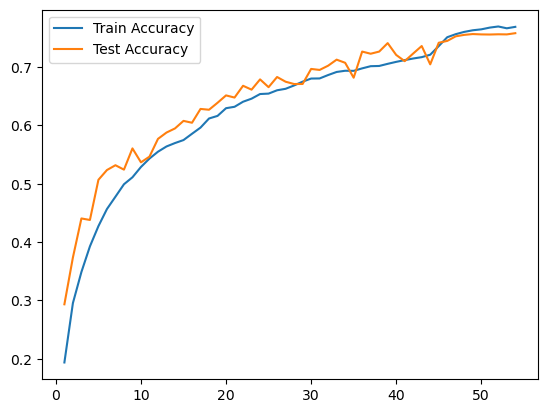

In [28]:
x = np.linspace(1,curr_epoch,curr_epoch)
plt.plot(x, train_acc_list, label = "Train Accuracy")
plt.plot(x, val_acc_list, label = "Test Accuracy")
plt.legend()


Evaluate test accuracy

In [29]:
model.eval()
test_acc = 0
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    predictions = model(images)
    accuracy = (torch.max(predictions, dim=-1, keepdim=True)[1].flatten() == labels).sum() / len(labels)
    test_acc += accuracy.item()
test_acc /= len(test_loader)
print(f"Test accuracy: {test_acc:.3f}")

Test accuracy: 0.758
